# LinkNet: Network for Semantic Segmentation

Abhishek Chaurasia, Eugenio Culurciello, Jun 2017, https://arxiv.org/abs/1707.03718

LinkNet architecture is inspired by auto-encoders: each encoder (decoder) performs downsampling (upsampling) the feature maps by a factor of 2. At the same time the number of channels increases (decreases) except the outputs of the first encoder-decoder blocks. The main novelty of LinkNet as a segmenation network is a usage of skip connections between encoders and decoders. This
approach enables to save spatial information that contains in input image and helps to train neural networks. Each convolutional layer is followed by batch-normalization and ReLU. 

<img src='./pic/01.PNG' width="400" height="300">

<img src='pic/02.PNG' width="1000" height="400">

We will use LinkNet to segmenation of $128 \times 128$ images with MNIST $28 \times 28$ at random place (uniformly sampled) with noise generated on the base of MNIST fragments. Each fragment is randomly cutted from random image from the same batch and is rotated by an angle $ \sim U(0,360^{\circ})$. Coordinates of top-left corner are sampled from uniform $U(0, 128-s)$ or normal $N\left(\frac{128-s}{2}, \left(\frac{128-s}{4}\right)^2\right)$ distribution where $s$ is equal to width (height) of rotated image.

In [1]:
import sys
from time import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

sys.path.append("..")
sys.path.append("../task_03")

from dataset import Pipeline, DatasetIndex, Dataset, B, C, F, V

from fcn import FCNModel
from linknet import LinkNetModel                                  # TFModel subclass with LinkNet
from nmnist import NoisedMnist                                          # Batch subclass with loading and noise actions
from plot_functions import plot_noised_image, plot_examples_highlighted # plot functions to demonstrate result 

Fix constants to generate noised images and train LinkNet:

In [19]:
IMAGE_SIZE = 64     # image size
MNIST_SIZE = 65000   # MNIST database size
BATCH_SIZE = 512     # batch size for NN training
MAX_ITER = 100       # number of iterations for NN training

Define noise parameters:

In [20]:
level = 1           # the highest level of noise; [0, 1]
n_fragments = 30    # number of noise fragments per image  
size = 8            # size of noise fragment; 1, ..., 27
distr = 'normal'    # distribution of fragments of image; 'uniform' or 'normal'

Create DatasetIndex and Dataset to use pipelines:

In [21]:
ind = DatasetIndex(np.arange(MNIST_SIZE))          # index for images
mnistset = Dataset(ind, batch_class=NoisedMnist)   # Dataset with transform actions in NoisedMnist class
mnistset.cv_split([0.9, 0.1])                      # divide it into train and test

Сreate Pipeline template for image loading and transformation. The first parameter of create_noise is the type of noise: 'mnist_noise' - MNIST-based noise, 'random_noise' - uniform random noise.

In [22]:
load_template = (Pipeline()
                 .load_images()                    # load MNIST images from file
                 .random_location(IMAGE_SIZE)      # put MNIST at random location
                 .create_mask()                    # create mask for MNIST image location
                 .create_noise('mnist_noise',
                            level,
                            n_fragments, 
                            size, 
                            distr))

Plot example of noised images (train images are greyscale but we highlight true digit in yellow to plot):

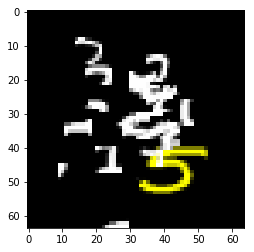

In [23]:
images = []
noise = []
(load_template << mnistset.train).get_images(images).get_noise(noise).next_batch(10, shuffle=True)
plot_noised_image(images[0][0], noise[0][0])

Create config for placeholders of the model. Key in dict is name of the created placeholder.
* '<b>shape</b>' - shape of the input of model
* '<b>type</b>' - tf.dtype of input
* '<b>data_format</b>' - one of channels_last (default) or channels_first
* '<b>name</b>' - name of the placeholder after reshaping 

In [24]:
placeholders_config = {
                       'input': {'shape': (IMAGE_SIZE, IMAGE_SIZE, 1),
                                 'type': 'float32',
                                 'data_format': 'channels_last'},
                
                       'masks': {'shape': (IMAGE_SIZE, IMAGE_SIZE, 2),
                                 'type': 'int32',
                                 'data_format': 'channels_last',
                                 'name': 'targets'}
                       }

Create model_config.
* '<b>placeholders</b>' - dict of placeholders configs
* '<b>n_classes</b>' - number of output classes
* '<b>b_norm</b>' - enable batch normalization
* '<b>loss</b>' - loss function
* '<b>optimizer</b>' - loss function

In [25]:
model_config = {'placeholders': placeholders_config,
                'n_classes': 2,
                'b_norm': False,
                'loss': 'softmax_cross_entropy',
                'optimizer': 'Adam'}

Create feed dicts. The key is name of the tensor in tf graph, value is batch component.

In [26]:
train_feed_dict = {'input': B('images'),
                   'masks': B('masks')}        

test_feed_dict = {'input': B('images'),
                  'masks': B('masks')}

Create train and test pipelines:

In [27]:
ppl_train = ((load_template << mnistset.train)
            .add_noise()
            .init_variable('train_loss_history', init_on_each_run=list)
            .init_model('static',                                          # model mode
                        LinkNetModel,                                      # TFModel subclass with LinkNet
                        'linknet',                                         # model name
                        config=model_config)
            .train_model('linknet',                                        # model name
                         fetches='loss',                                   # tensors to get value 
                         feed_dict=train_feed_dict,                        
                         append_to=V('train_loss_history')))                  # name of pipeline variable to save loss value

ppl_test = ((load_template << mnistset.test)
            .add_noise()
            .import_model('linknet', ppl_train)
            .init_variable('test_loss_history', init_on_each_run=list)
            .predict_model('linknet', 
                           fetches='loss',
                           feed_dict=test_feed_dict,
                           append_to=V('test_loss_history')))

Train LinkNet on noised data:

In [33]:
# training of the model

start = time()

for i in range(MAX_ITER):
    ppl_train.next_batch(BATCH_SIZE, n_epochs=None, shuffle=True)                              # training step
    ppl_test.next_batch(100, n_epochs=None, shuffle=True)                                      # compute test loss
    
    train_loss = ppl_train.get_variable('train_loss_history')[-1]                # get current iteration train loss
    test_loss = ppl_test.get_variable('test_loss_history')[-1]                   # get current iteration test loss
    
    if (i+1) % 10 == 0:
        print("Iter {:3d}: train {:05.3f} test {:05.3f}".format(i+1, train_loss, test_loss))
        
stop = time()

print("Train time: {:05.3f} min".format((stop-start)/60))

Iter  10: train 0.685 test 0.673
Iter  20: train 0.633 test 0.729
Iter  30: train 0.672 test 0.616
Iter  40: train 0.581 test 0.594
Iter  50: train 0.541 test 0.548
Iter  60: train 0.555 test 0.528
Iter  70: train 0.571 test 0.584
Iter  80: train 0.496 test 0.441
Iter  90: train 0.449 test 0.455
Iter 100: train 0.417 test 0.403
Train time: 72.523 min


Plot train and test loss:

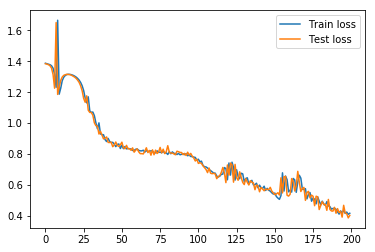

In [34]:
plt.plot(ppl_train.get_variable('train_loss_history'), label='Train loss')
plt.plot(ppl_test.get_variable('test_loss_history'), label='Test loss')
plt.legend()
plt.show()

Create pipeline to get some images from test dataset and corresponding masks, noise and mask predictions:

In [35]:
images = []
masks = []
noise = []

ppl_plot = ((load_template << mnistset.test)                       # load data from file
             .get_images(images)                                   # images without noise
             .get_masks(masks)                                     # get masks
             .get_noise(noise)                                     # get noise
             .add_noise()                                          # add noise to images
             .import_model('linknet', ppl_train)
             .init_variable('predictions', init_on_each_run=list)
             .predict_model('linknet',                                      
                           fetches='predicted_prob',
                           feed_dict=test_feed_dict,
                           append_to=V('predictions')))

Get predictions for 10 images:

In [31]:
ppl_plot.next_batch(10, n_epochs=None)
predictions = ppl_plot.get_variable('predictions')[-1]

Plot images with highlighted digit, mask for $28 \times 28$ image, binary mask prediction and probability prediction:

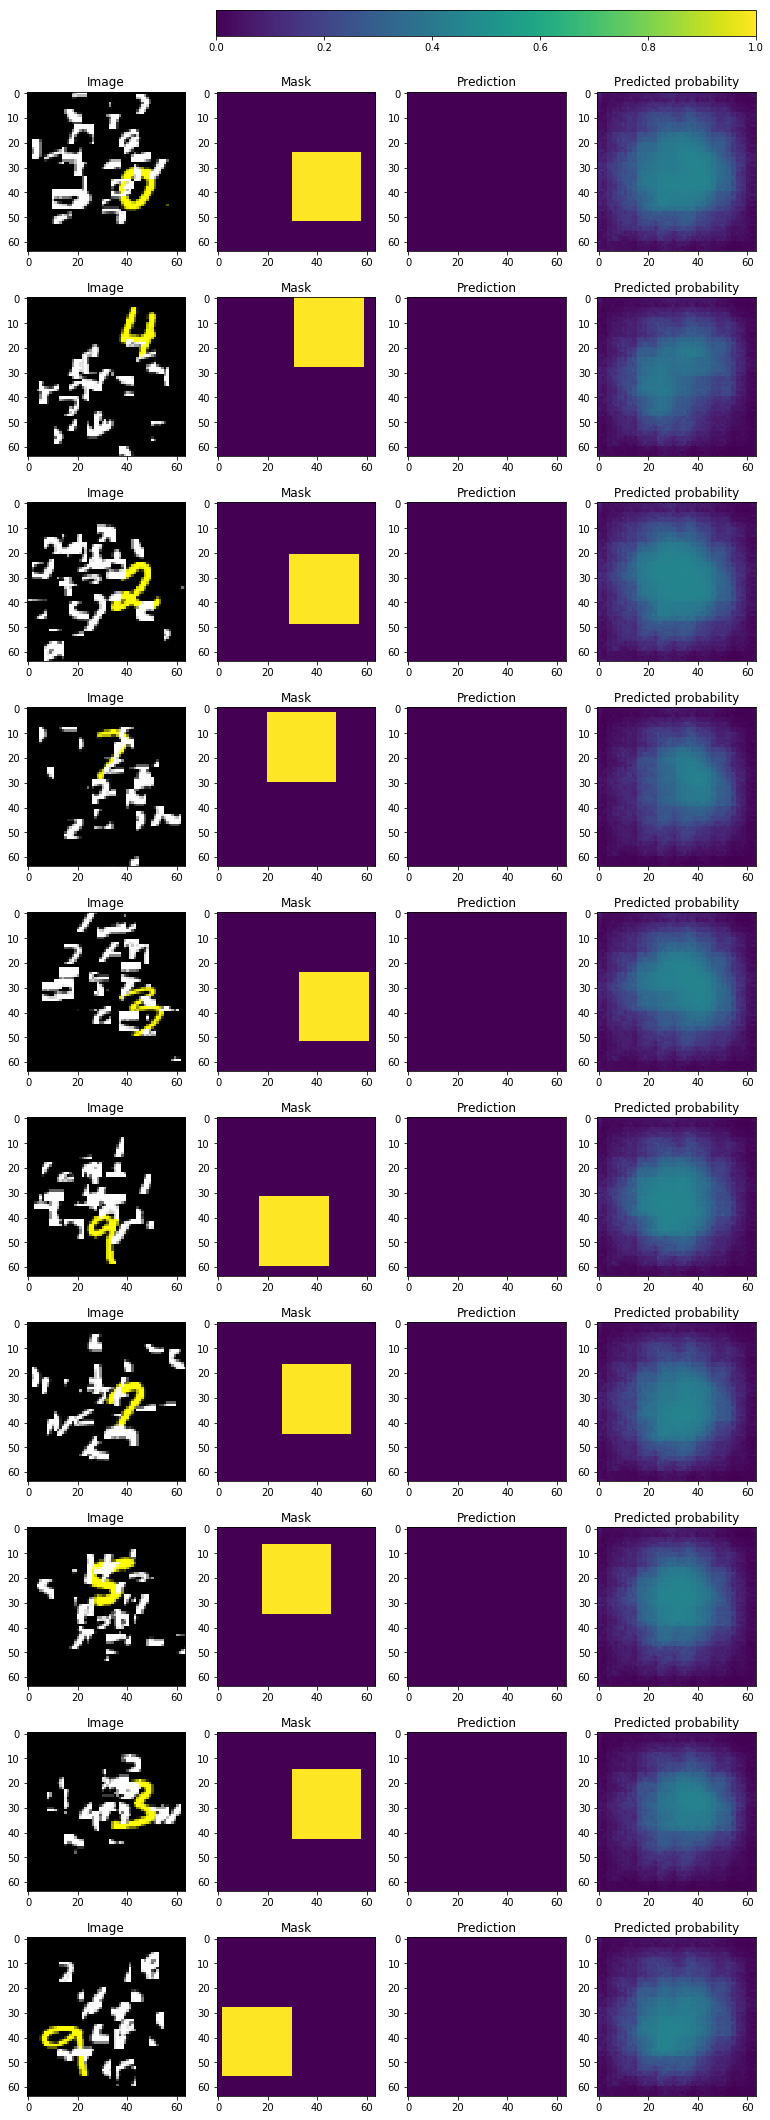

In [32]:
plot_examples_highlighted(images, noise, masks, predictions)